# Weather Underground Hurricane Data

-----

## Processed Data Research

A notebook for researching the processed Weather Underground data from the ```src/process_data.py``` script.

In [1]:
processed_data_dir = '../data/processed/'
media_dir = '../media'

In [2]:
# Imports
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Load Data
with open(os.path.join(processed_data_dir, 'region_data.pkl'), 'rb') as fin:
    region_df = pickle.load(fin)

with open(os.path.join(processed_data_dir, 'region_yearly_data.pkl'), 'rb') as fin:
    region_yearly_df = pickle.load(fin)

with open(os.path.join(processed_data_dir, 'storm_track_data.pkl'), 'rb') as fin:
    storm_track_dict = pickle.load(fin)

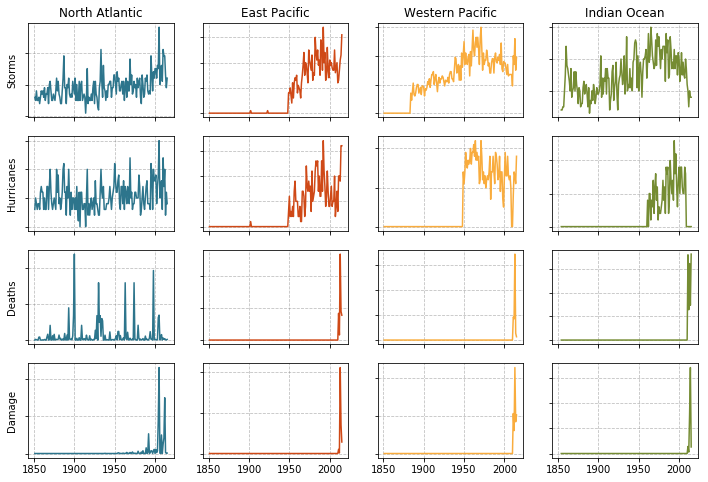

In [4]:
# - Plot data by region
regions = ['North Atlantic', 'East Pacific', 'Western Pacific', 'Indian Ocean']

stats = ['Storms', 'Hurricanes', 'Deaths', 'Damage']

colors = ['#2d758c', '#cf4917', '#f9ac3d', '#758c33']
color_dict = dict(zip(regions, colors))

fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, figsize=(12, 8))

i_col = 0
for region in regions:
    t_reg_df = region_df.loc[:, region]
    
    i_row = 0
    for statistic in stats:
        ax = axs[i_row][i_col]
        clr = color_dict[region]
        t_reg_df.loc[:, statistic].plot(ax=ax, color=clr)
        ax.grid(linestyle='--', color='grey', alpha=0.5)
        
        ax.set_yticklabels([])
        if i_col == 0:
            ax.set_ylabel(statistic)
    
        if i_row == 0:
            ax.set_title(region)
    
        i_row += 1
    
    i_col += 1

fig.savefig(os.path.join(media_dir, 'region_data_by_region_stat.png'))
plt.show();

In [5]:
# - Get common starting date
plt_start = region_df.first_valid_index()
for region in set(region_df.columns.get_level_values('Region')):
    t_df = region_df.loc[:, pd.IndexSlice[region, 'Hurricanes']]
    t_df[t_df == 0.] = np.nan
    t_start_dt = t_df.first_valid_index()
    
    if t_start_dt > plt_start:
        plt_start = t_start_dt

print("Common starting date: {}".format(plt_start))

Common starting date: 1961


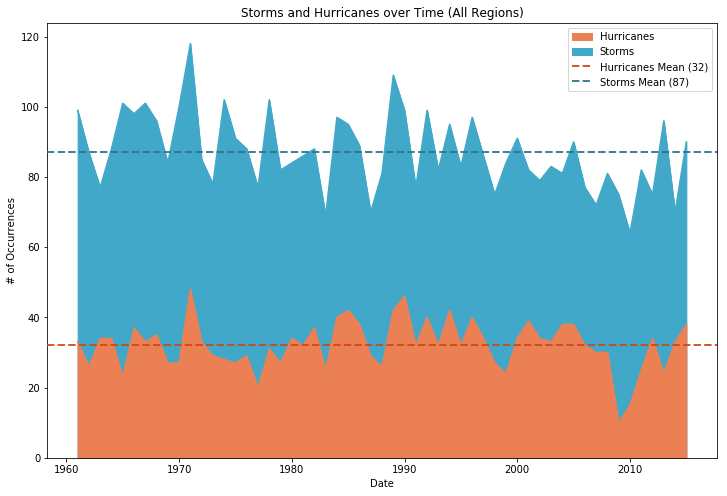

In [6]:
# - Total occurences over time
agg_data = region_df.groupby(level='Statistic', axis=1).sum().loc[plt_start:]
pct_hurricanes = agg_data.loc[:, 'Hurricanes'] / agg_data.loc[:, 'Storms']

avg_counts = agg_data.loc[:, ['Hurricanes', 'Storms']].mean().values
avg_pct = pct_hurricanes.mean()

# - Plot
plot_percentages = False

fig, ax = plt.subplots(figsize=(12, 8))

agg_data.loc[:, 'Storms'].plot.area(ax=ax, alpha=1, color='#41a8c9', zorder=1)
agg_data.loc[:, 'Hurricanes'].plot.area(ax=ax, alpha=1, color='#ec8055', zorder=2)

ax.axhline(avg_counts[1], label='Storms Mean ({:.0f})'.format(avg_counts[1]),
           color='#2d758c', alpha=0.9, linestyle='--', linewidth=2, zorder=3)
ax.axhline(avg_counts[0], label='Hurricanes Mean ({:.0f})'.format(avg_counts[0]),
           color='#cf4917', alpha=0.9, linestyle='--', linewidth=2, zorder=3)

ax.set_title('Storms and Hurricanes over Time (All Regions)')
ax.set_ylabel('# of Occurrences');
ax.set_xlabel('Date')

lines, labels = ax.get_legend_handles_labels()
if plot_percentages:
    ax2 = (pct_hurricanes * 100.).plot(ax=ax, secondary_y=True, zorder=4, linestyle='-',
                                       color='#d0b285', linewidth=2.5, 
                                       label='Percent Hurricanes')
    ax2.axhline(avg_pct*100., label='Percent Mean ({:.1f}%)'.format(100.*avg_pct),
                color='#a2783c', alpha=0.9, linestyle='--', linewidth=2, zorder=5)

    ax2.set_ylim((0, 100))
    ax2.set_ylabel('Percent (%)')

    
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax.legend(lines[::-1]+lines_2, labels[::-1]+labels_2, loc='upper right')
else:
    ax.legend(lines[::-1], labels[::-1], loc='upper right')
    

fig.savefig(os.path.join(media_dir, 'storms_hurricanes_all_regions.png'))
plt.show();

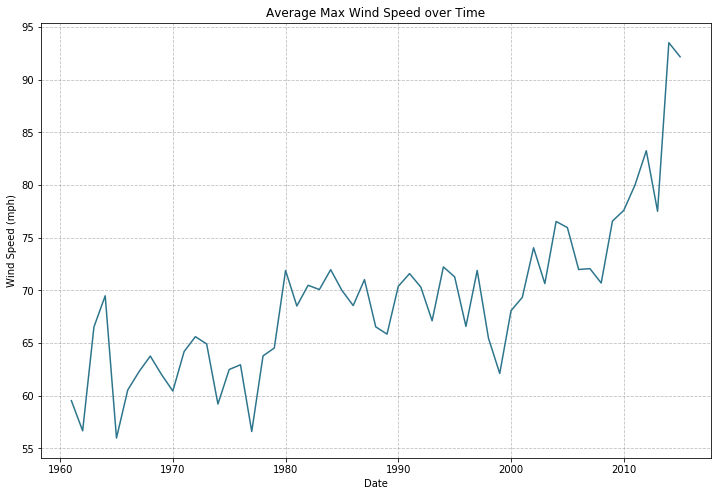

In [7]:
# - Get avg max winds data
start_dates = region_yearly_df.loc[:, ['Start Date']].set_index('Start Date').index
cut_region_yearly = region_yearly_df.loc[start_dates.year >= plt_start, :]
cut_start_dates = cut_region_yearly.loc[:, ['Start Date']].set_index('Start Date').index

avg_max_wind_speed = cut_region_yearly.loc[:, 'Max Winds'].groupby(cut_start_dates.year).mean()

# - Plot
fig, ax = plt.subplots(figsize=(12, 8))

avg_max_wind_speed.plot(ax=ax, color='#2d758c')
ax.grid(linestyle='--', color='grey', alpha=0.5)

ax.set_title('Average Max Wind Speed over Time')
ax.set_ylabel('Wind Speed (mph)')
ax.set_xlabel('Date')

fig.savefig(os.path.join(media_dir, 'avg_max_wind_speed_by_year.png'))
plt.show();

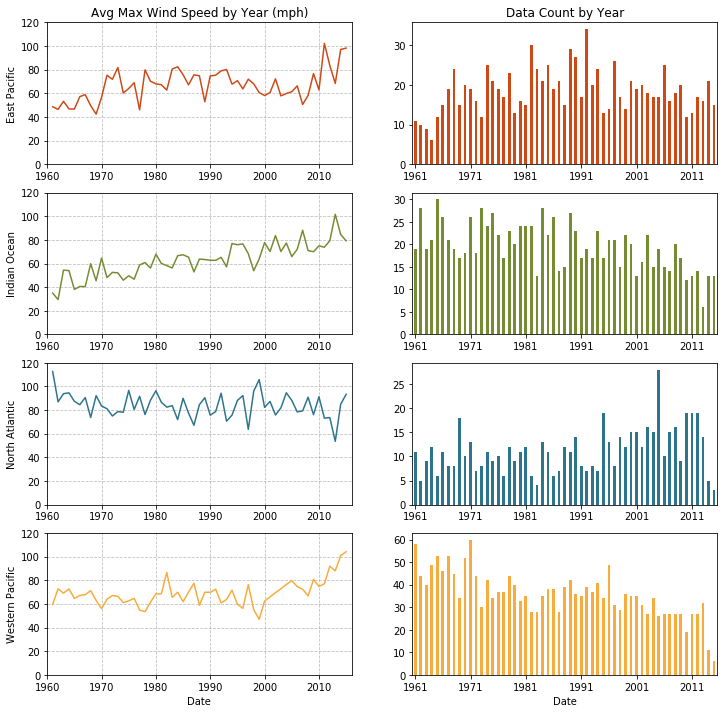

In [8]:
# - Avg Max Wind Speed by Region
reg_avgmaxwind = cut_region_yearly.groupby(['Region', cut_start_dates.year], axis=0) \
                                  .mean().loc[:, 'Max Winds'].unstack('Region')
reg_counts = cut_region_yearly.groupby(['Region', cut_start_dates.year], axis=0).count() \
                              .loc[:, 'Max Winds'].unstack('Region')

# - Plot
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False, figsize=(12, 12))

i = 0
for reg in reg_avgmaxwind.columns:
    ax = axs[i][0]
    reg_avgmaxwind.loc[:, reg].plot(ax=ax, label=reg, color=color_dict[reg])
    ax.set_ylim((0, 120))
    ax.set_xlim((1960, 2016))
    ax.grid(linestyle='--', color='grey', alpha=0.5)
    ax.set_ylabel(reg)
    ax.set_xlabel('')
        
    ax = axs[i][1]
    reg_counts.loc[:, reg].plot(ax=ax, kind='bar', label='Count', color=color_dict[reg])
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.xaxis.set_ticklabels([plt_start] + list(range(plt_start, 2015, 10)), rotation=0)
    ax.set_xlabel('')
    
    i += 1

axs[0][0].set_title('Avg Max Wind Speed by Year (mph)')
axs[0][1].set_title('Data Count by Year')
axs[-1][0].set_xlabel('Date')
axs[-1][1].set_xlabel('Date')

fig.savefig(os.path.join(media_dir, 'avg_max_winds_by_region.png'))
plt.show();

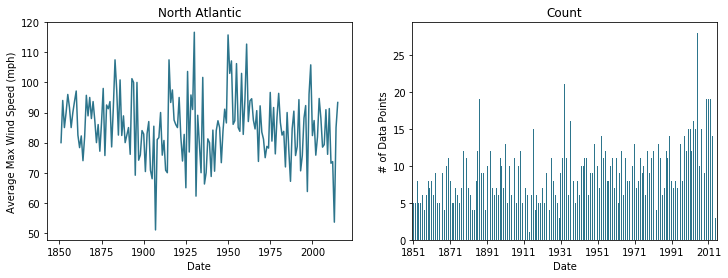

In [9]:
# - North Atlantic Specific Focus
allyr_avgmaxwind = region_yearly_df.groupby(['Region', start_dates.year], axis=0) \
                                   .mean().loc[:, 'Max Winds'].unstack('Region')
allyr_counts = region_yearly_df.groupby(['Region', start_dates.year], axis=0) \
                               .count().loc[:, 'Max Winds'].unstack('Region')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax = axs[0]
allyr_avgmaxwind.loc[:, 'North Atlantic'].plot(ax=ax, color=color_dict['North Atlantic'])

ax.set_title('North Atlantic')
ax.set_ylabel('Average Max Wind Speed (mph)')
ax.set_xlabel('Date')

ax = axs[1]
allyr_counts.loc[:, 'North Atlantic'].plot(ax=ax, kind='bar', label='Count', 
                                           color=color_dict['North Atlantic'])

disp_mult = 20
ax.xaxis.set_major_locator(plt.MultipleLocator(disp_mult))
ax.xaxis.set_ticklabels([allyr_counts.index[0]] + 
                        list(range(allyr_counts.index[0], 2015, disp_mult)), 
                        rotation=0)
ax.set_title('Count')
ax.set_ylabel('# of Data Points')
ax.set_xlabel('Date')

fig.savefig(os.path.join(media_dir, 'north_atlantic_max_wind_speed_all.png'))
plt.show();

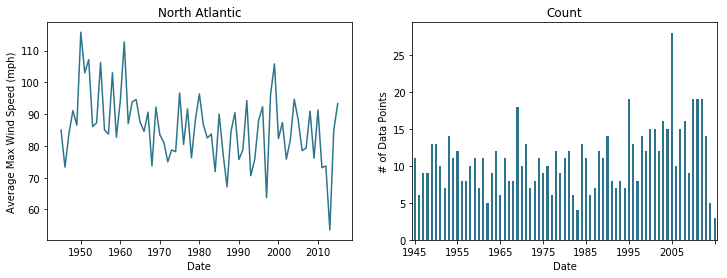

In [10]:
# - 1945 Onward for North Atlantic
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax = axs[0]
allyr_avgmaxwind.loc[1945:, 'North Atlantic'].plot(ax=ax, 
                                                   color=color_dict['North Atlantic'])

ax.set_title('North Atlantic')
ax.set_ylabel('Average Max Wind Speed (mph)')
ax.set_xlabel('Date')

ax = axs[1]
allyr_counts.loc[1945:, 'North Atlantic'].plot(ax=ax, kind='bar', label='Count', 
                                               color=color_dict['North Atlantic'])

disp_mult = 10
ax.xaxis.set_major_locator(plt.MultipleLocator(disp_mult))
ax.xaxis.set_ticklabels([1945] + list(range(1945, 2015, disp_mult)), 
                        rotation=0)
ax.set_title('Count')
ax.set_ylabel('# of Data Points')
ax.set_xlabel('Date')

fig.savefig(os.path.join(media_dir, 'north_atlantic_max_wind_speed_1945.png'))
plt.show();

In [11]:
# - Tack on IsHurricane Columns to Regional-Yearly data
def _classify_helper(storm_name):
    """Helper function to classify 'hurricanes'"""
    ret = False
    designations = ['hurricane', 'typhoon']
    
    storm_name = storm_name.lower()
    for designation in designations:
        ret |= storm_name.startswith(designation)
    
    return ret

regyr_wclass = region_yearly_df.copy()

is_hurricane = np.zeros((regyr_wclass.shape[0], 1))
for row_id, vals in enumerate(regyr_wclass.values):
    is_hurricane[row_id] = 1 if _classify_helper(vals[1]) else 0

regyr_wclass['IsHurricane'] = is_hurricane

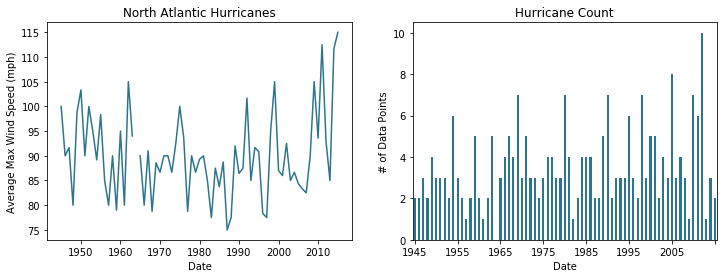

In [12]:
# - 1945 Onward for North Atlantic (Hurricanes Only)
hurricane_data = regyr_wclass.loc[regyr_wclass.loc[:, 'IsHurricane'] == 1] \
                             .drop('IsHurricane', axis=1)
hurricane_years = hurricane_data.loc[:, ['Start Date']].set_index('Start Date').index

regavg_hurricanes = hurricane_data.groupby(['Region', hurricane_years.year], axis=0) \
                                  .mean().loc[:, 'Max Winds'].unstack('Region')
regcnt_hurricanes = hurricane_data.groupby(['Region', hurricane_years.year], axis=0) \
                                  .count().loc[:, 'Max Winds'].unstack('Region')

# -- Plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax = axs[0]
regavg_hurricanes.loc[1945:, 'North Atlantic'].plot(ax=ax, 
                                                    color=color_dict['North Atlantic'])

ax.set_title('North Atlantic Hurricanes')
ax.set_ylabel('Average Max Wind Speed (mph)')
ax.set_xlabel('Date')

ax = axs[1]
regcnt_hurricanes.loc[1945:, 'North Atlantic'].plot(ax=ax, kind='bar', label='Count', 
                                                    color=color_dict['North Atlantic'])

disp_mult = 10
ax.xaxis.set_major_locator(plt.MultipleLocator(disp_mult))
ax.xaxis.set_ticklabels([1945] + list(range(1945, 2015, disp_mult)), 
                        rotation=0)
ax.set_title('Hurricane Count')
ax.set_ylabel('# of Data Points')
ax.set_xlabel('Date')

fig.savefig(os.path.join(media_dir, 'north_atlantic_hurricanes_max_wind_speed_1945.png'))
plt.show();

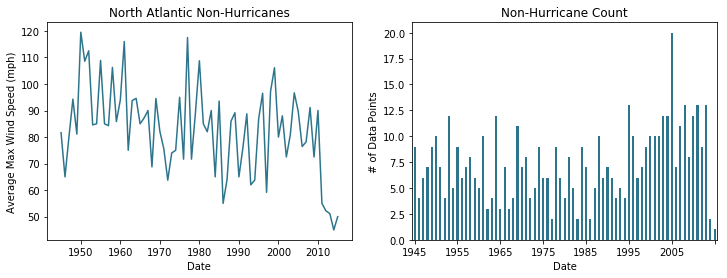

In [13]:
# - 1945 Onward for North Atlantic (Hurricanes Only)
non_hurr_data = regyr_wclass.loc[regyr_wclass.loc[:, 'IsHurricane'] == 0] \
                            .drop('IsHurricane', axis=1)
non_hurr_years = non_hurr_data.loc[:, ['Start Date']].set_index('Start Date').index

regavg_nonhurrs = non_hurr_data.groupby(['Region', non_hurr_years.year], axis=0) \
                               .mean().loc[:, 'Max Winds'].unstack('Region')
regcnt_nonhurrs = non_hurr_data.groupby(['Region', non_hurr_years.year], axis=0) \
                               .count().loc[:, 'Max Winds'].unstack('Region')

# -- Plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax = axs[0]
regavg_nonhurrs.loc[1945:, 'North Atlantic'].plot(ax=ax, 
                                                  color=color_dict['North Atlantic'])

ax.set_title('North Atlantic Non-Hurricanes')
ax.set_ylabel('Average Max Wind Speed (mph)')
ax.set_xlabel('Date')

ax = axs[1]
regcnt_nonhurrs.loc[1945:, 'North Atlantic'].plot(ax=ax, kind='bar', label='Count', 
                                                  color=color_dict['North Atlantic'])

disp_mult = 10
ax.xaxis.set_major_locator(plt.MultipleLocator(disp_mult))
ax.xaxis.set_ticklabels([1945] + list(range(1945, 2015, disp_mult)), 
                        rotation=0)
ax.set_title('Non-Hurricane Count')
ax.set_ylabel('# of Data Points')
ax.set_xlabel('Date')

fig.savefig(os.path.join(media_dir, 'north_atlantic_non_hurricanes_max_wind_speed_1945.png'))
plt.show();

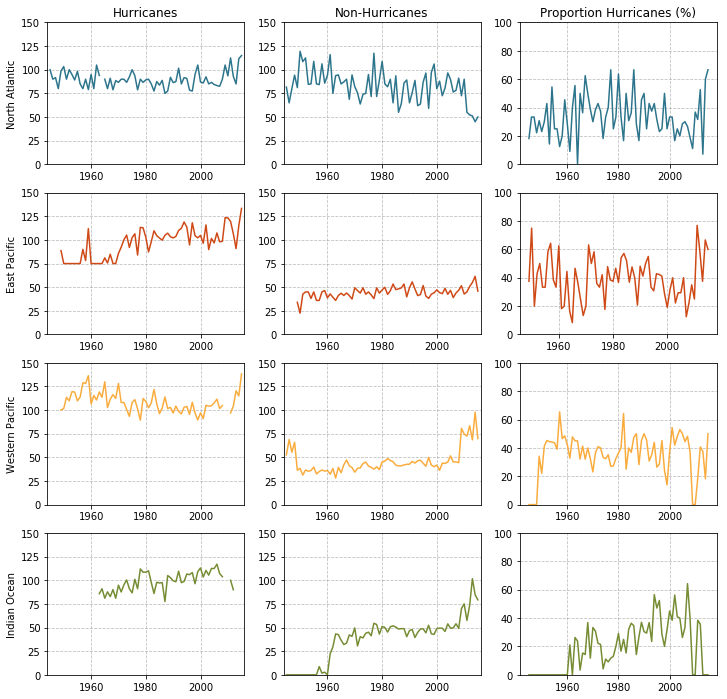

In [14]:
# - Hurricanes vs. Non-hurricanes by Region
hurr_prop = (regcnt_hurricanes.fillna(0) / (regcnt_nonhurrs + regcnt_hurricanes.fillna(0)))

# -- Plot
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

for i_reg in range(len(regions)):
    reg = regions[i_reg]
    
    ax = axs[i_reg][0]
    regavg_hurricanes.loc[1945:, reg].plot(ax=ax, color=color_dict[reg])
    ax.set_ylim((0, 150))
    ax.set_xlim((1944, 2016))
    ax.grid(linestyle='--', color='grey', alpha=0.5)
    ax.set_ylabel(reg)
    ax.set_xlabel('')
    
    ax = axs[i_reg][1]
    regavg_nonhurrs.loc[1945:, reg].plot(ax=ax, color=color_dict[reg])
    ax.set_ylim((0, 150))
    ax.set_xlim((1944, 2016))
    ax.grid(linestyle='--', color='grey', alpha=0.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    ax = axs[i_reg][2]
    (hurr_prop * 100.).loc[1945:, reg].plot(ax=ax, color=color_dict[reg])
    ax.grid(linestyle='--', color='grey', alpha=0.5)
    ax.set_ylim(0, 100)
    ax.set_xlabel('')
    
axs[0][0].set_title('Hurricanes')
axs[0][1].set_title('Non-Hurricanes')
axs[0][2].set_title('Proportion Hurricanes (%)')

fig.savefig(os.path.join(media_dir, 'hurr_vs_non_hurr_stats_region.png'))
plt.show();